In [11]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#cross-validation
from sklearn.model_selection import cross_val_score

#resampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import tree
from imblearn.metrics import classification_report_imbalanced
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

#reports
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

In [3]:
#Importing clean data
pickleFile = open('X_dummies.pickle', 'rb')
X = pickle.load(pickleFile)
pickleFile.close()

pickleFile = open('y.pickle', 'rb')
y = pickle.load(pickleFile)
pickleFile.close()

#### Train/Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y,
                              test_size=.2, random_state=42)

#### Feature Importance

In [5]:
forest_selection = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest_selection.fit(X_train, y_train)
importances = forest_selection.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_selection.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

<ipython-input-5-3b6cef20e260>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_selection.fit(X_train, y_train)


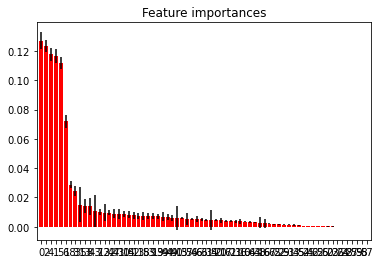

In [6]:
#Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
         color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [7]:
#selecting the most important features
number_selected_features = 25
X_train, X_test = X_train.values[:, indices[:number_selected_features]], X_test.values[:, indices[:number_selected_features]]
y_train, y_test = y_train.values, y_test.values

In [8]:
featurenames =X.columns
for i in indices[:25]:
    print(featurenames[i])

geo_level_1_id
geo_level_3_id
age
geo_level_2_id
area_percentage
height_percentage
count_families
count_floors_pre_eq
foundation_type_r
has_superstructure_timber
has_superstructure_mud_mortar_stone
ground_floor_type_v
has_superstructure_adobe_mud
has_superstructure_cement_mortar_brick
land_surface_condition_t
other_floor_type_q
ground_floor_type_f
land_surface_condition_n
has_superstructure_bamboo
position_s
has_superstructure_mud_mortar_brick
roof_type_n
position_t
has_superstructure_stone_flag
has_secondary_use


#### Scaling my data

In [9]:
X = preprocessing.minmax_scale(X)
X_test = preprocessing.minmax_scale(X_test)

#### Methods for under comparison

In [21]:
Methods_sampling = [
    (RandomUnderSampler(sampling_strategy='not minority', random_state=42), 'RUS'),
    (RandomOverSampler(sampling_strategy = 'not majority', random_state = 42), 'ROS'),
    (SMOTE(sampling_strategy = 'not majority', random_state = 42, k_neighbors = 1), 'smote_1'),
    (SMOTE(sampling_strategy = 'not majority', random_state = 42, k_neighbors = 5), 'smote_5'), 
]


Methods_learn = [
    (tree.DecisionTreeClassifier(random_state = 42, max_depth=6), 'DT6'),
    (tree.DecisionTreeClassifier(random_state = 42, max_depth=12), 'DT12'),
    (tree.DecisionTreeClassifier(random_state = 42, max_depth=32), 'DT32'),
    (RandomForestClassifier(n_estimators= 50, criterion = 'gini'), 'RF_50'),
    (RandomForestClassifier(n_estimators= 100, criterion = 'gini'), 'RF_100'), 
    (KNeighborsClassifier(n_neighbors = 5), 'KNN_5'), 
    (KNeighborsClassifier(n_neighbors = 15), 'KNN_15'),
    (LogisticRegression(C = 1, max_iter=3000, solver = 'sag', random_state = 42), 'LR'),
    (GradientBoostingClassifier(random_state = 42), 'GB_default'),
    (GradientBoostingClassifier(n_estimators=500, random_state = 42), 'GB_ne500'),
    (GradientBoostingClassifier(n_estimators=500, max_depth=10, random_state = 42), 'GB_ne500md10'),
    (AdaBoostClassifier(), 'AB'),
    (LinearSVC(C = 0.1, random_state = 42, max_iter=10000), 'LSVC_0.1'),
    (LinearSVC(C = 1, random_state = 42, max_iter=10000), 'LSVC_1'),
    (LinearSVC(C = 10, random_state = 42, max_iter=10000), 'LSVC_10'),
    (GaussianNB(), 'Gaussian'),
]

#### Metrics

In [22]:
dict_results = {}

recalls = []
precisions = []
f1 = []
methods = []

#### Running the algorithms with cross-validation

In [27]:
for sampler, samplerName in Methods_sampling:
    for model, modelName in Methods_learn:
        print(samplerName, modelName)
        Ks = StratifiedKFold(n_splits = 10, random_state = 42, shuffle= True) # Create Object
        Ks.get_n_splits(X_train, y_train) # Preparar para experiment
        
        recalls_fold = []
        precisions_fold = []
        f1_fold = []

        
        for train_idx, val_idx in Ks.split(X_train, y_train):
            xTrain_fold, yTrain_fold = X_train[train_idx, :], y_train[train_idx] 
            xVal_fold, yVal_fold = X_train[val_idx, :], y_train[val_idx] 

    
            xTrain_resample, yTrain_resample = sampler.fit_sample(xTrain_fold, yTrain_fold)
                                                                  
            model.fit(xTrain_resample, yTrain_resample)
                                                                  
            yPred = model.predict(xVal_fold)

            recalls_fold.append([recall_score(yVal_fold,yPred, average = None)])
            precisions_fold.append([precision_score(yVal_fold,yPred, average = None)])
            f1_fold.append([f1_score(yVal_fold,yPred, average = None)])

            methods.append(samplerName+"-"+modelName)
        recalls_fold = np.vstack(recalls_fold)
        precisions_fold = np.vstack(precisions_fold)
        f1_fold = np.vstack(f1_fold)
        
        recalls.append(recalls_fold.mean(axis = 0))
        precisions.append(precisions_fold.mean(axis = 0))
        f1.append(f1_fold.mean(axis = 0))

RUS DT6
RUS DT12
RUS DT32
RUS RF_50
RUS RF_100
RUS KNN_5
RUS KNN_15
RUS LR


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: Convergenc

RUS GB_default
RUS GB_ne500
RUS GB_ne500md10
RUS AB
RUS LSVC_0.1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

RUS LSVC_1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

RUS LSVC_10


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

RUS Gaussian
ROS DT6
ROS DT12
ROS DT32
ROS RF_50
ROS RF_100
ROS KNN_5
ROS KNN_15
ROS LR


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: Convergenc

ROS GB_default
ROS GB_ne500
ROS GB_ne500md10
ROS AB
ROS LSVC_0.1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

ROS LSVC_1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

ROS LSVC_10


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

ROS Gaussian
smote_1 DT6
smote_1 DT12
smote_1 DT32
smote_1 RF_50
smote_1 RF_100
smote_1 KNN_5
smote_1 KNN_15
smote_1 LR


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: Convergenc

smote_1 GB_default
smote_1 GB_ne500
smote_1 GB_ne500md10
smote_1 AB
smote_1 LSVC_0.1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

smote_1 LSVC_1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

smote_1 LSVC_10


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

smote_1 Gaussian
smote_5 DT6
smote_5 DT12
smote_5 DT32
smote_5 RF_50
smote_5 RF_100
smote_5 KNN_5
smote_5 KNN_15
smote_5 LR


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: Convergenc

smote_5 GB_default
smote_5 GB_ne500
smote_5 GB_ne500md10
smote_5 AB
smote_5 LSVC_0.1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

smote_5 LSVC_1


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/li

smote_5 LSVC_10


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

smote_5 Gaussian


### Organizing scores for comparison

In [1]:
recalls = np.vstack(recalls)
precisions = np.vstack(precisions)
f1 = np.vstack(f1)

recalls = pd.DataFrame(recalls.T, columns = methods)
precisions = pd.DataFrame(precisions.T, columns = methods)
f1 = pd.DataFrame(f1.T, columns = methods)

recalls.to_excel('recalls_multiclass.xlsx')
precisions.to_excel('precisions_multiclass.xlsx')
f1.to_excel('f1_multiclass.xlsx')

NameError: name 'np' is not defined

### Selected Model
Getting final scores and confusion matrix on test set with the selected algorithm

                   pre       rec       spe        f1       geo       iba       sup

          1       0.35      0.59      0.88      0.44      0.72      0.51       579
          2       0.57      0.84      0.17      0.68      0.38      0.16      3413
          3       0.42      0.01      0.99      0.01      0.09      0.01      2008

avg / total       0.50      0.54      0.52      0.43      0.32      0.14      6000



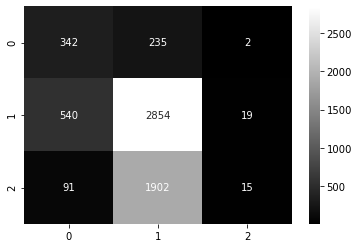

In [12]:
selected_model = tree.DecisionTreeClassifier(random_state = 42, max_depth=6)
selected_sampler = RandomOverSampler(sampling_strategy = 'not majority', random_state = 42)

xTrain_resample, yTrain_resample = selected_sampler.fit_sample(X_train, y_train)
selected_model.fit(xTrain_resample, yTrain_resample)
yPred = selected_model.predict(X_test)


recalls_test = recall_score(y_test,yPred, average = None)
precisions_test = precision_score(y_test,yPred, average = None)
f1_test = f1_score(y_test,yPred, average = None)

plt.figure()
confusion_m = confusion_matrix(y_test,yPred)
#sns.heatmap(confusion_m/confusion_m.sum()*100, annot=True)
sns.heatmap(confusion_m, annot=True, fmt="d", cmap="gray")

print(classification_report_imbalanced(y_test,yPred))

All combinations were compared. Although random forest gave us better precision for the class we were most interested (Complete Destruction), the decision tree gave us a better recall, therefore we selected decision tree combined with random over sampling. For future work, we will run this with a tree ensemble. 